In [1]:
!pip install pandas

In [2]:
import os
import re
import shutil
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models,transforms,datasets
from tqdm import tqdm
from tqdm import tqdm_notebook
# import scikit-learn as sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.model_selection import KFold
import itertools

/var/folders/kk/6q2jd0hj56z_vzsn0nsr_bf40000gn/T/ipykernel_26005/3086419938.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Use available device

In [3]:
device = "cpu"
if torch.cuda.is_available():
    print("using gpu")
    device = torch.device("gpu")
elif torch.backends.mps.is_available():
    print("using mps")
    device = torch.device("mps")

using mps


## Data loader

In [4]:
resized_images = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

In [5]:
data_dir = '../Data/brain_tumor/brain_tumor_dataset/'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=resized_images) for x in ['train', 'test']}

In [6]:
train_loader = torch.utils.data.DataLoader(dsets['train'], batch_size=8, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dsets['test'], batch_size=8, shuffle=False, num_workers=2)

## Training and test functions

In [7]:
def train(model,data_loader,loss_fn,optimizer,n_epochs=1,verbose=True):
    model = model.to(device)
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    for epoch_num in range(n_epochs): #tqdm(range(n_epochs)):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bs = labels.size(0)
            output = model.forward(inputs)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = output.max(1, keepdim=True)[1]
            running_loss += loss
            running_corrects += pred.eq(labels.view_as(pred)).sum()
            size += bs
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        if verbose:
            print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return loss_train, acc_train

In [8]:
def test(model,data_loader):
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        bs = labels.size(0)

        output = model.forward(inputs)
        loss = loss_fn(output, labels)

        pred = output.max(1, keepdim=True)[1]
        running_loss += loss
        running_corrects += pred.eq(labels.view_as(pred)).sum()

        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [9]:
def train_and_test(model,data_loader_train, data_loader_test,loss_fn,optimizer,n_epochs=1):
    model = model.to(device)
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    loss_test = np.zeros(n_epochs)
    acc_test = np.zeros(n_epochs)
    
    for epoch_num in tqdm(range(n_epochs)):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader_train:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bs = labels.size(0)
            output = model.forward(inputs)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = output.max(1, keepdim=True)[1]
            running_loss += loss
            running_corrects += pred.eq(labels.view_as(pred)).sum()
            size += bs
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader_test:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bs = labels.size(0)

            output = model.forward(inputs)
            loss = loss_fn(output, labels)

            pred = output.max(1, keepdim=True)[1]
            running_loss += loss
            running_corrects += pred.eq(labels.view_as(pred)).sum()

            size += bs

        print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))
        loss_test[epoch_num] = running_loss / size
        acc_test[epoch_num] = running_corrects.item() / size
        
    return loss_train, acc_train, loss_test, acc_test

In [10]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    labels_all = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    
    return labels_all, predictions

In [11]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (4, 4))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## EfficientNet

### EfficientNet b7

Best accuracy

In [12]:
model_eff_net7 = models.efficientnet_b7(weights='DEFAULT')

In [13]:
model_eff_net7 = model_eff_net7.to(device)

In [14]:
print(model_eff_net7)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [15]:
for param in model_eff_net7.parameters():
    param.requires_grad = False

model_eff_net7.classifier._modules['1'] = nn.Linear(2560, 2)
model_eff_net7.classifier._modules['2'] = torch.nn.LogSoftmax(dim = 1)

In [16]:
print(model_eff_net7)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [17]:
model_eff_net7 = model_eff_net7.to(device)

In [18]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_eff_net7.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_eff_net7, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 30)

  0%|          | 0/30 [00:00<?, ?it/s]

Train - Loss: 0.1864 Acc: 0.7321


  3%|▎         | 1/30 [00:32<15:47, 32.66s/it]

Test - Loss: 0.2955 Acc: 0.5529
Train - Loss: 0.1243 Acc: 0.7738


  7%|▋         | 2/30 [01:01<14:19, 30.70s/it]

Test - Loss: 0.4051 Acc: 0.5529
Train - Loss: 0.0914 Acc: 0.8095


 10%|█         | 3/30 [01:31<13:34, 30.16s/it]

Test - Loss: 0.4146 Acc: 0.5529
Train - Loss: 0.1193 Acc: 0.8095


 13%|█▎        | 4/30 [02:00<12:55, 29.84s/it]

Test - Loss: 0.3837 Acc: 0.5529
Train - Loss: 0.0782 Acc: 0.8452


 17%|█▋        | 5/30 [02:30<12:25, 29.81s/it]

Test - Loss: 0.3956 Acc: 0.5176
Train - Loss: 0.0970 Acc: 0.8214


 20%|██        | 6/30 [03:00<11:52, 29.69s/it]

Test - Loss: 0.3957 Acc: 0.5529
Train - Loss: 0.0849 Acc: 0.8452


 23%|██▎       | 7/30 [03:29<11:21, 29.63s/it]

Test - Loss: 0.3997 Acc: 0.6000
Train - Loss: 0.1102 Acc: 0.8452


 27%|██▋       | 8/30 [03:59<10:51, 29.62s/it]

Test - Loss: 0.3864 Acc: 0.5294
Train - Loss: 0.0878 Acc: 0.8750


 30%|███       | 9/30 [04:28<10:21, 29.62s/it]

Test - Loss: 0.3831 Acc: 0.5529
Train - Loss: 0.0643 Acc: 0.8810


 33%|███▎      | 10/30 [04:58<09:54, 29.73s/it]

Test - Loss: 0.4834 Acc: 0.5882
Train - Loss: 0.0757 Acc: 0.8631


 37%|███▋      | 11/30 [05:28<09:24, 29.72s/it]

Test - Loss: 0.4381 Acc: 0.6000
Train - Loss: 0.0649 Acc: 0.8810


 40%|████      | 12/30 [05:57<08:52, 29.56s/it]

Test - Loss: 0.4132 Acc: 0.5412
Train - Loss: 0.0747 Acc: 0.8393


 43%|████▎     | 13/30 [06:26<08:20, 29.45s/it]

Test - Loss: 0.4895 Acc: 0.5412
Train - Loss: 0.0988 Acc: 0.8393


 47%|████▋     | 14/30 [06:56<07:50, 29.40s/it]

Test - Loss: 0.6073 Acc: 0.4941
Train - Loss: 0.0742 Acc: 0.8631


 50%|█████     | 15/30 [07:25<07:22, 29.49s/it]

Test - Loss: 0.4271 Acc: 0.5412
Train - Loss: 0.0751 Acc: 0.8810


 53%|█████▎    | 16/30 [07:55<06:52, 29.44s/it]

Test - Loss: 0.4697 Acc: 0.4706
Train - Loss: 0.0986 Acc: 0.8750


 57%|█████▋    | 17/30 [08:25<06:24, 29.59s/it]

Test - Loss: 0.4170 Acc: 0.5765
Train - Loss: 0.0839 Acc: 0.8452


 60%|██████    | 18/30 [08:54<05:54, 29.54s/it]

Test - Loss: 0.4611 Acc: 0.5294
Train - Loss: 0.1025 Acc: 0.8274


 63%|██████▎   | 19/30 [09:24<05:25, 29.59s/it]

Test - Loss: 0.5345 Acc: 0.5176
Train - Loss: 0.0567 Acc: 0.8631


 67%|██████▋   | 20/30 [09:53<04:54, 29.48s/it]

Test - Loss: 0.5047 Acc: 0.4824
Train - Loss: 0.0545 Acc: 0.9107


 70%|███████   | 21/30 [10:23<04:25, 29.53s/it]

Test - Loss: 0.5235 Acc: 0.5412
Train - Loss: 0.0693 Acc: 0.9048


 73%|███████▎  | 22/30 [10:52<03:56, 29.59s/it]

Test - Loss: 0.5205 Acc: 0.6118
Train - Loss: 0.0847 Acc: 0.8452


 77%|███████▋  | 23/30 [11:22<03:27, 29.60s/it]

Test - Loss: 0.4128 Acc: 0.5882
Train - Loss: 0.1018 Acc: 0.8393


 80%|████████  | 24/30 [11:51<02:57, 29.56s/it]

Test - Loss: 0.5429 Acc: 0.5647
Train - Loss: 0.1131 Acc: 0.8452


 83%|████████▎ | 25/30 [12:21<02:27, 29.53s/it]

Test - Loss: 0.4483 Acc: 0.6118
Train - Loss: 0.0226 Acc: 0.9405


 87%|████████▋ | 26/30 [12:50<01:58, 29.50s/it]

Test - Loss: 0.4662 Acc: 0.5765
Train - Loss: 0.0836 Acc: 0.8571


 90%|█████████ | 27/30 [13:19<01:28, 29.39s/it]

Test - Loss: 0.5710 Acc: 0.5765
Train - Loss: 0.1064 Acc: 0.8452


 93%|█████████▎| 28/30 [13:49<00:58, 29.34s/it]

Test - Loss: 0.5000 Acc: 0.6000
Train - Loss: 0.0781 Acc: 0.8631


 97%|█████████▋| 29/30 [14:18<00:29, 29.47s/it]

Test - Loss: 0.4713 Acc: 0.6471
Train - Loss: 0.0732 Acc: 0.8929


100%|██████████| 30/30 [14:48<00:00, 29.62s/it]

Test - Loss: 0.5829 Acc: 0.5765


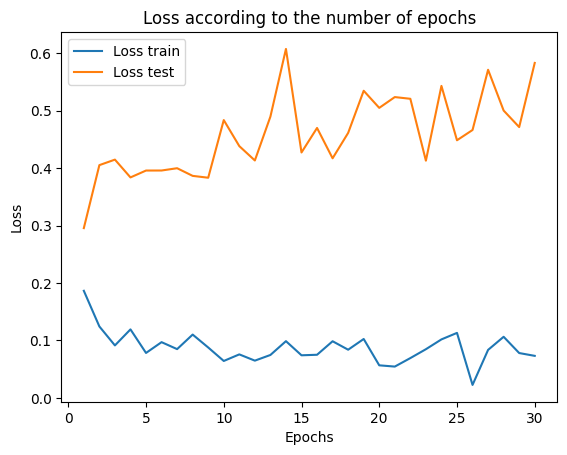

In [19]:
plt.plot(np.arange(1,31), loss_train, label='Loss train')
plt.plot(np.arange(1,31), loss_test, label='Loss test')
plt.legend()
plt.title('Loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

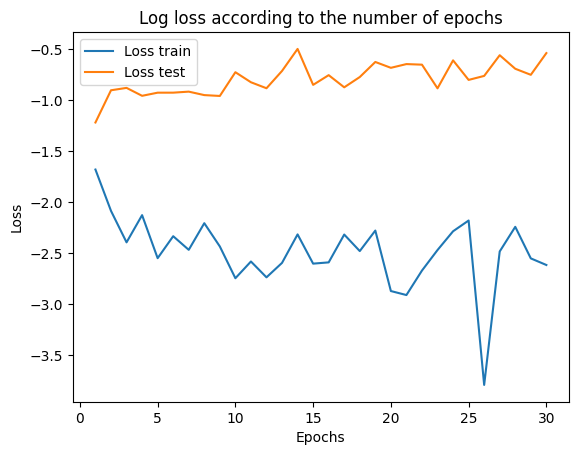

In [20]:
plt.plot(np.arange(1,31), np.log(loss_train), label='Loss train')
plt.plot(np.arange(1,31), np.log(loss_test), label='Loss test')
plt.legend()
plt.title('Log loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

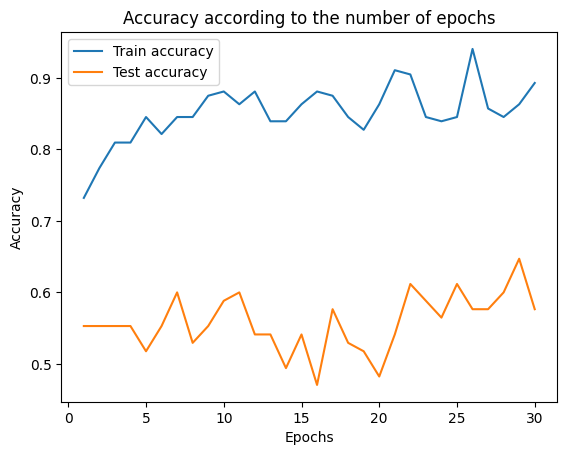

In [21]:
plt.plot(np.arange(1,31), acc_train, label='Train accuracy')
plt.plot(np.arange(1,31), acc_test, label='Test accuracy')
plt.legend()
plt.title('Accuracy according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Confusion Matrix, Without Normalization


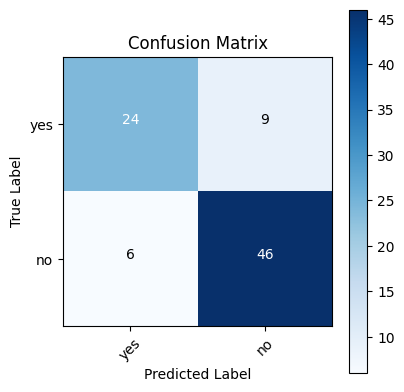

              precision    recall  f1-score   support

         yes       0.80      0.73      0.76        33
          no       0.84      0.88      0.86        52

    accuracy                           0.82        85
   macro avg       0.82      0.81      0.81        85
weighted avg       0.82      0.82      0.82        85



In [22]:
labels, predictions = predict(model_eff_net7, test_loader)

target_names = ['yes','no']

cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

print(classification_report(labels, predictions, target_names= target_names))

### EfficientNet b6

Less parameters than the b7

In [23]:
model_eff_net6 = models.efficientnet_b6(weights='DEFAULT')

In [24]:
model_eff_net6 = model_eff_net6.to(device)

In [25]:
print(model_eff_net6)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [26]:
for param in model_eff_net6.parameters():
    param.requires_grad = False

model_eff_net6.classifier._modules['1'] = nn.Linear(2304, 2)
model_eff_net6.classifier._modules['2'] = torch.nn.LogSoftmax(dim = 1)

In [27]:
print(model_eff_net6)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [28]:
model_eff_net6 = model_eff_net6.to(device)

In [29]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_eff_net6.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_eff_net6, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 30)

  0%|          | 0/30 [00:00<?, ?it/s]

Train - Loss: 0.2166 Acc: 0.6548


  3%|▎         | 1/30 [00:31<15:14, 31.52s/it]

Test - Loss: 0.3414 Acc: 0.4941
Train - Loss: 0.1031 Acc: 0.7738


  7%|▋         | 2/30 [01:00<14:04, 30.17s/it]

Test - Loss: 0.4268 Acc: 0.5059
Train - Loss: 0.0971 Acc: 0.8274


 10%|█         | 3/30 [01:29<13:17, 29.52s/it]

Test - Loss: 0.3416 Acc: 0.5647
Train - Loss: 0.1187 Acc: 0.8095


 13%|█▎        | 4/30 [01:58<12:41, 29.29s/it]

Test - Loss: 0.3858 Acc: 0.5529
Train - Loss: 0.0735 Acc: 0.8393


 17%|█▋        | 5/30 [02:27<12:06, 29.07s/it]

Test - Loss: 0.3960 Acc: 0.5059
Train - Loss: 0.0551 Acc: 0.8690


 20%|██        | 6/30 [02:55<11:33, 28.91s/it]

Test - Loss: 0.4044 Acc: 0.5765
Train - Loss: 0.1194 Acc: 0.8095


 23%|██▎       | 7/30 [03:24<11:05, 28.95s/it]

Test - Loss: 0.4355 Acc: 0.4471
Train - Loss: 0.0898 Acc: 0.8512


 27%|██▋       | 8/30 [03:54<10:39, 29.08s/it]

Test - Loss: 0.3767 Acc: 0.5059
Train - Loss: 0.1267 Acc: 0.8214


 30%|███       | 9/30 [04:23<10:13, 29.22s/it]

Test - Loss: 0.4839 Acc: 0.4588
Train - Loss: 0.0848 Acc: 0.8631


 33%|███▎      | 10/30 [04:53<09:47, 29.35s/it]

Test - Loss: 0.3898 Acc: 0.5176
Train - Loss: 0.0941 Acc: 0.8571


 37%|███▋      | 11/30 [05:21<09:13, 29.14s/it]

Test - Loss: 0.4407 Acc: 0.4941
Train - Loss: 0.1121 Acc: 0.8155


 40%|████      | 12/30 [05:50<08:43, 29.06s/it]

Test - Loss: 0.4332 Acc: 0.5059
Train - Loss: 0.0885 Acc: 0.8571


 43%|████▎     | 13/30 [06:20<08:17, 29.27s/it]

Test - Loss: 0.3931 Acc: 0.5294
Train - Loss: 0.1023 Acc: 0.8393


 47%|████▋     | 14/30 [06:50<07:49, 29.36s/it]

Test - Loss: 0.4461 Acc: 0.5176
Train - Loss: 0.0719 Acc: 0.8631


 50%|█████     | 15/30 [07:18<07:17, 29.19s/it]

Test - Loss: 0.3679 Acc: 0.5412
Train - Loss: 0.0676 Acc: 0.8631


 53%|█████▎    | 16/30 [07:49<06:56, 29.74s/it]

Test - Loss: 0.3983 Acc: 0.4588
Train - Loss: 0.1083 Acc: 0.8571


 57%|█████▋    | 17/30 [08:19<06:26, 29.71s/it]

Test - Loss: 0.4085 Acc: 0.4941
Train - Loss: 0.0884 Acc: 0.8512


 60%|██████    | 18/30 [08:49<05:56, 29.72s/it]

Test - Loss: 0.4665 Acc: 0.5294
Train - Loss: 0.0895 Acc: 0.8631


 63%|██████▎   | 19/30 [09:18<05:26, 29.68s/it]

Test - Loss: 0.3915 Acc: 0.5765
Train - Loss: 0.0810 Acc: 0.8333


 67%|██████▋   | 20/30 [09:48<04:55, 29.52s/it]

Test - Loss: 0.4771 Acc: 0.4353
Train - Loss: 0.0493 Acc: 0.8810


 70%|███████   | 21/30 [10:16<04:23, 29.27s/it]

Test - Loss: 0.4560 Acc: 0.4471
Train - Loss: 0.0767 Acc: 0.8393


 73%|███████▎  | 22/30 [10:45<03:54, 29.26s/it]

Test - Loss: 0.3862 Acc: 0.5176
Train - Loss: 0.1184 Acc: 0.8214


 77%|███████▋  | 23/30 [11:15<03:25, 29.34s/it]

Test - Loss: 0.4736 Acc: 0.5176
Train - Loss: 0.0794 Acc: 0.8512


 80%|████████  | 24/30 [11:44<02:55, 29.32s/it]

Test - Loss: 0.3666 Acc: 0.5412
Train - Loss: 0.0988 Acc: 0.8393


 83%|████████▎ | 25/30 [12:14<02:27, 29.48s/it]

Test - Loss: 0.5627 Acc: 0.4588
Train - Loss: 0.0692 Acc: 0.8750


 87%|████████▋ | 26/30 [12:44<01:58, 29.67s/it]

Test - Loss: 0.4215 Acc: 0.5529
Train - Loss: 0.0712 Acc: 0.8631


 90%|█████████ | 27/30 [13:13<01:28, 29.35s/it]

Test - Loss: 0.3784 Acc: 0.5647
Train - Loss: 0.0854 Acc: 0.8750


 93%|█████████▎| 28/30 [13:41<00:58, 29.09s/it]

Test - Loss: 0.4405 Acc: 0.5412
Train - Loss: 0.1060 Acc: 0.8333


 97%|█████████▋| 29/30 [14:11<00:29, 29.13s/it]

Test - Loss: 0.3118 Acc: 0.5059
Train - Loss: 0.0719 Acc: 0.8750


100%|██████████| 30/30 [14:40<00:00, 29.34s/it]

Test - Loss: 0.4340 Acc: 0.5294


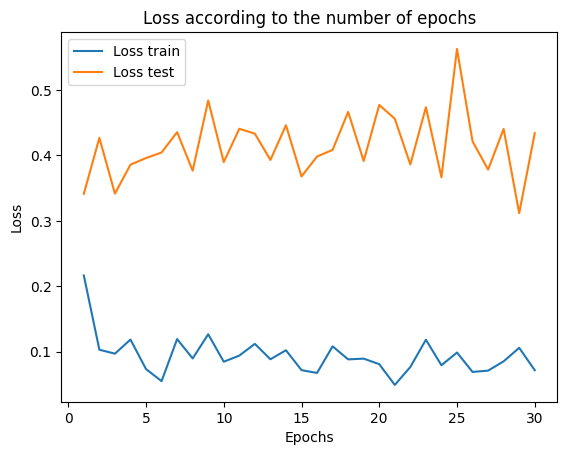

In [30]:
plt.plot(np.arange(1,31), loss_train, label='Loss train')
plt.plot(np.arange(1,31), loss_test, label='Loss test')
plt.legend()
plt.title('Loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

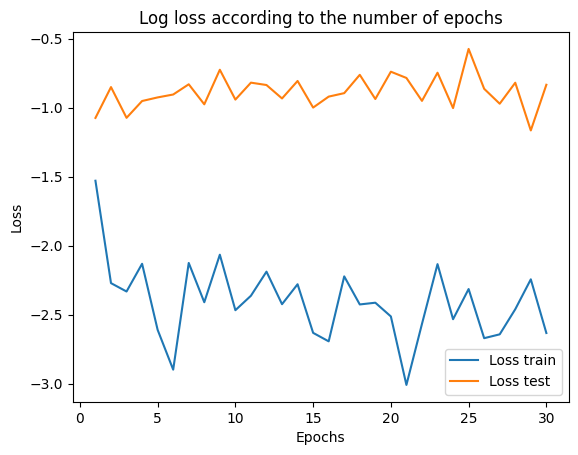

In [31]:
plt.plot(np.arange(1,31), np.log(loss_train), label='Loss train')
plt.plot(np.arange(1,31), np.log(loss_test), label='Loss test')
plt.legend()
plt.title('Log loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

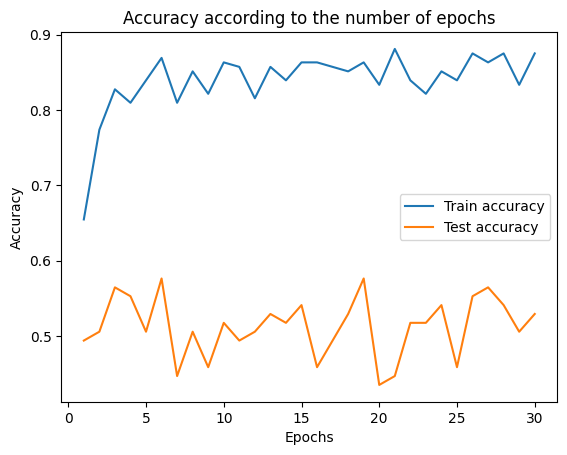

In [32]:
plt.plot(np.arange(1,31), acc_train, label='Train accuracy')
plt.plot(np.arange(1,31), acc_test, label='Test accuracy')
plt.legend()
plt.title('Accuracy according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Confusion Matrix, Without Normalization


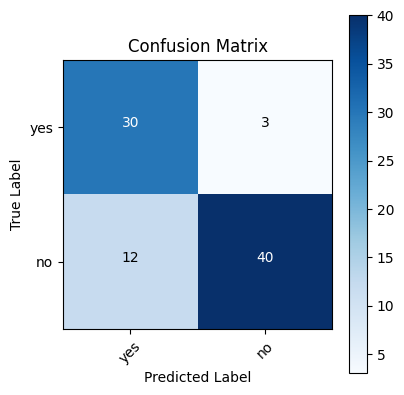

              precision    recall  f1-score   support

         yes       0.71      0.91      0.80        33
          no       0.93      0.77      0.84        52

    accuracy                           0.82        85
   macro avg       0.82      0.84      0.82        85
weighted avg       0.85      0.82      0.83        85



In [33]:
labels, predictions = predict(model_eff_net6, test_loader)

target_names = ['yes','no']

cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

print(classification_report(labels, predictions, target_names= target_names))

### EfficientNet b1
Less hyperparameters

In [34]:
model_eff_net1 = models.efficientnet_b1(weights='DEFAULT')

In [35]:
model_eff_net1 = model_eff_net1.to(device)

In [36]:
print(model_eff_net1)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [37]:
for param in model_eff_net1.parameters():
    param.requires_grad = False

model_eff_net1.classifier._modules['1'] = nn.Linear(1280, 2)
model_eff_net1.classifier._modules['2'] = torch.nn.LogSoftmax(dim = 1)

In [38]:
print(model_eff_net1)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [39]:
model_eff_net1 = model_eff_net1.to(device)

In [40]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_eff_net1.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_eff_net1, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 0.0857 Acc: 0.7143


 10%|█         | 1/10 [00:30<04:32, 30.24s/it]

Test - Loss: 0.1822 Acc: 0.6118
Train - Loss: 0.0651 Acc: 0.8155


 20%|██        | 2/10 [00:57<03:47, 28.40s/it]

Test - Loss: 0.1916 Acc: 0.6353
Train - Loss: 0.0495 Acc: 0.8393


 30%|███       | 3/10 [01:24<03:15, 27.90s/it]

Test - Loss: 0.2320 Acc: 0.5765
Train - Loss: 0.0423 Acc: 0.8631


 40%|████      | 4/10 [01:51<02:45, 27.62s/it]

Test - Loss: 0.1913 Acc: 0.5412
Train - Loss: 0.0255 Acc: 0.9167


 50%|█████     | 5/10 [02:19<02:17, 27.58s/it]

Test - Loss: 0.1768 Acc: 0.6118
Train - Loss: 0.0507 Acc: 0.8631


 60%|██████    | 6/10 [02:46<01:49, 27.43s/it]

Test - Loss: 0.1744 Acc: 0.6353
Train - Loss: 0.0358 Acc: 0.8810


 70%|███████   | 7/10 [03:13<01:22, 27.35s/it]

Test - Loss: 0.1988 Acc: 0.5765
Train - Loss: 0.0339 Acc: 0.8690


 80%|████████  | 8/10 [03:41<00:54, 27.40s/it]

Test - Loss: 0.2114 Acc: 0.5647
Train - Loss: 0.0371 Acc: 0.8571


 90%|█████████ | 9/10 [04:08<00:27, 27.34s/it]

Test - Loss: 0.2115 Acc: 0.5647
Train - Loss: 0.0333 Acc: 0.9048


100%|██████████| 10/10 [04:35<00:00, 27.56s/it]

Test - Loss: 0.1757 Acc: 0.5765


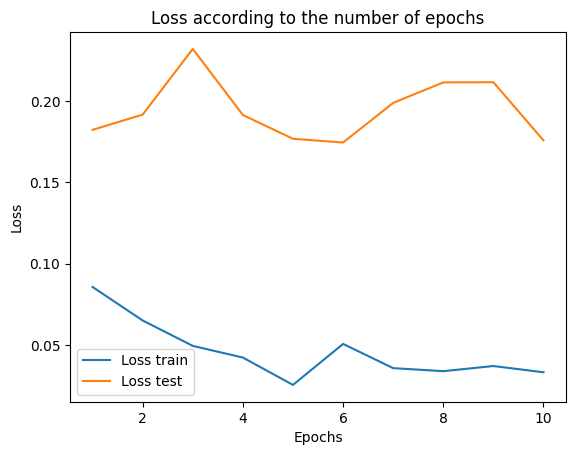

In [41]:
plt.plot(np.arange(1,11), loss_train, label='Loss train')
plt.plot(np.arange(1,11), loss_test, label='Loss test')
plt.legend()
plt.title('Loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

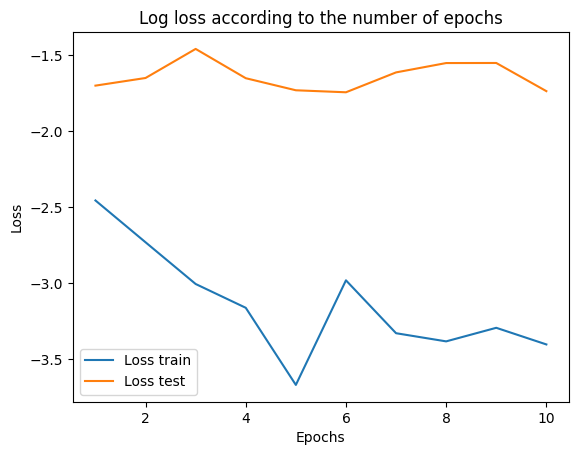

In [42]:
plt.plot(np.arange(1,11), np.log(loss_train), label='Loss train')
plt.plot(np.arange(1,11), np.log(loss_test), label='Loss test')
plt.legend()
plt.title('Log loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

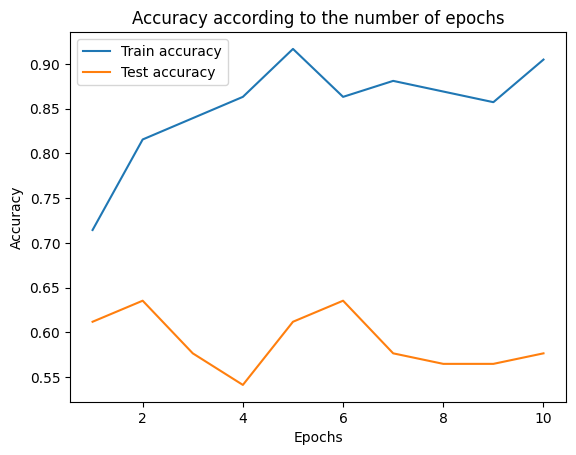

In [43]:
plt.plot(np.arange(1,11), acc_train, label='Train accuracy')
plt.plot(np.arange(1,11), acc_test, label='Test accuracy')
plt.legend()
plt.title('Accuracy according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Confusion Matrix, Without Normalization


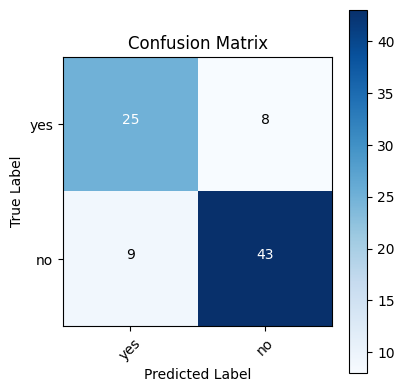

              precision    recall  f1-score   support

         yes       0.74      0.76      0.75        33
          no       0.84      0.83      0.83        52

    accuracy                           0.80        85
   macro avg       0.79      0.79      0.79        85
weighted avg       0.80      0.80      0.80        85



In [44]:
labels, predictions = predict(model_eff_net1, test_loader)

target_names = ['yes','no']

cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

print(classification_report(labels, predictions, target_names= target_names))

### EfficientNet b0
The simplest

In [45]:
model_eff_net0 = models.efficientnet_b0(weights='DEFAULT')

In [46]:
model_eff_net0 = model_eff_net0.to(device)

In [47]:
print(model_eff_net0)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [48]:
for param in model_eff_net0.parameters():
    param.requires_grad = False

model_eff_net0.classifier._modules['1'] = nn.Linear(1280, 2)
model_eff_net0.classifier._modules['2'] = torch.nn.LogSoftmax(dim = 1)

In [49]:
print(model_eff_net0)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [50]:
model_eff_net0 = model_eff_net0.to(device)

In [51]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_eff_net0.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_eff_net0, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 0.2518 Acc: 0.6667


 10%|█         | 1/10 [00:27<04:06, 27.42s/it]

Test - Loss: 0.3975 Acc: 0.5882
Train - Loss: 0.1021 Acc: 0.8274


 20%|██        | 2/10 [00:54<03:36, 27.09s/it]

Test - Loss: 0.2924 Acc: 0.5294
Train - Loss: 0.0884 Acc: 0.8452


 30%|███       | 3/10 [01:21<03:09, 27.10s/it]

Test - Loss: 0.2742 Acc: 0.6353
Train - Loss: 0.0815 Acc: 0.8452


 40%|████      | 4/10 [01:48<02:42, 27.07s/it]

Test - Loss: 0.2616 Acc: 0.6000
Train - Loss: 0.0699 Acc: 0.8750


 50%|█████     | 5/10 [02:15<02:14, 26.96s/it]

Test - Loss: 0.2813 Acc: 0.5882
Train - Loss: 0.0502 Acc: 0.8810


 60%|██████    | 6/10 [02:42<01:47, 27.00s/it]

Test - Loss: 0.2757 Acc: 0.6235
Train - Loss: 0.0567 Acc: 0.8750


 70%|███████   | 7/10 [03:09<01:20, 26.92s/it]

Test - Loss: 0.3154 Acc: 0.5059
Train - Loss: 0.0442 Acc: 0.8333


 80%|████████  | 8/10 [03:35<00:53, 26.94s/it]

Test - Loss: 0.2916 Acc: 0.6000
Train - Loss: 0.0710 Acc: 0.8810


 90%|█████████ | 9/10 [04:02<00:26, 26.88s/it]

Test - Loss: 0.3197 Acc: 0.5059
Train - Loss: 0.0457 Acc: 0.9048


100%|██████████| 10/10 [04:30<00:00, 27.01s/it]

Test - Loss: 0.3519 Acc: 0.5765


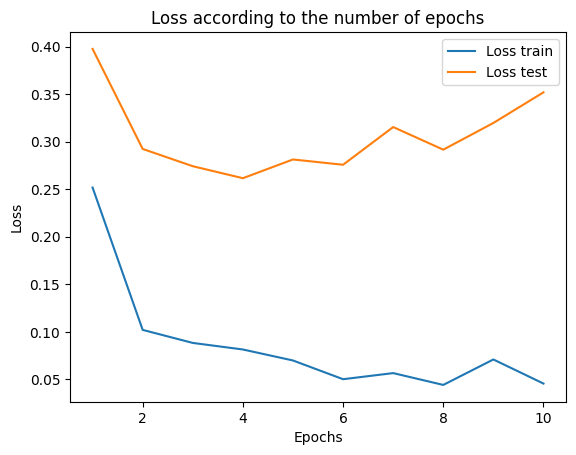

In [52]:
plt.plot(np.arange(1,11), loss_train, label='Loss train')
plt.plot(np.arange(1,11), loss_test, label='Loss test')
plt.legend()
plt.title('Loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

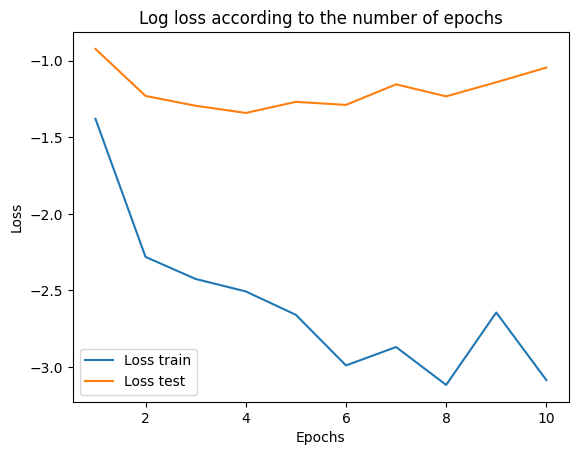

In [53]:
plt.plot(np.arange(1,11), np.log(loss_train), label='Loss train')
plt.plot(np.arange(1,11), np.log(loss_test), label='Loss test')
plt.legend()
plt.title('Log loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

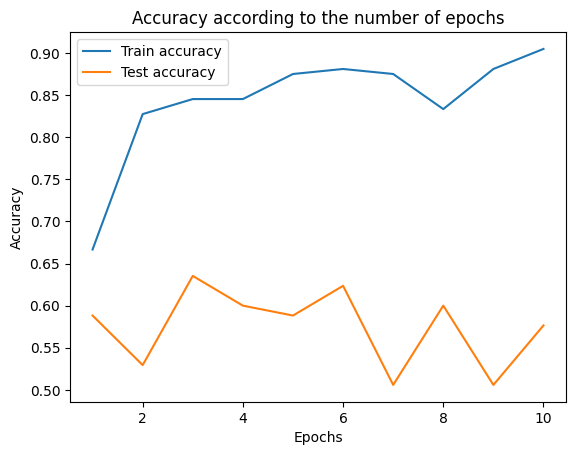

In [54]:
plt.plot(np.arange(1,11), acc_train, label='Train accuracy')
plt.plot(np.arange(1,11), acc_test, label='Test accuracy')
plt.legend()
plt.title('Accuracy according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Confusion Matrix, Without Normalization


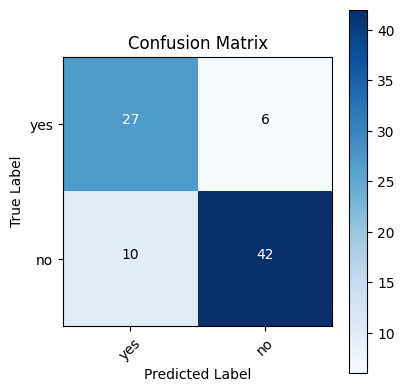

              precision    recall  f1-score   support

         yes       0.73      0.82      0.77        33
          no       0.88      0.81      0.84        52

    accuracy                           0.81        85
   macro avg       0.80      0.81      0.81        85
weighted avg       0.82      0.81      0.81        85



In [55]:
labels, predictions = predict(model_eff_net0, test_loader)

target_names = ['yes','no']

cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

print(classification_report(labels, predictions, target_names= target_names))

### EfficientNet b2
Less hyperparameters

In [56]:
model_eff_net2 = models.efficientnet_b2(weights='DEFAULT')

In [57]:
model_eff_net2 = model_eff_net2.to(device)

In [58]:
print(model_eff_net2)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [59]:
for param in model_eff_net2.parameters():
    param.requires_grad = False

model_eff_net2.classifier._modules['1'] = nn.Linear(1408, 2)
model_eff_net2.classifier._modules['2'] = torch.nn.LogSoftmax(dim = 1)

In [60]:
print(model_eff_net2)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [61]:
model_eff_net2 = model_eff_net2.to(device)

In [62]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_eff_net2.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_eff_net2, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 0.2657 Acc: 0.6726


 10%|█         | 1/10 [00:29<04:28, 29.82s/it]

Test - Loss: 0.3405 Acc: 0.5176
Train - Loss: 0.1414 Acc: 0.7679


 20%|██        | 2/10 [00:57<03:46, 28.30s/it]

Test - Loss: 0.4046 Acc: 0.5529
Train - Loss: 0.1138 Acc: 0.7917


 30%|███       | 3/10 [01:24<03:13, 27.70s/it]

Test - Loss: 0.3445 Acc: 0.5647
Train - Loss: 0.1055 Acc: 0.8333


 40%|████      | 4/10 [01:51<02:45, 27.52s/it]

Test - Loss: 0.4252 Acc: 0.5176
Train - Loss: 0.0990 Acc: 0.8393


 50%|█████     | 5/10 [02:19<02:18, 27.70s/it]

Test - Loss: 0.4394 Acc: 0.5529
Train - Loss: 0.1334 Acc: 0.7976


 60%|██████    | 6/10 [02:47<01:51, 27.98s/it]

Test - Loss: 0.4085 Acc: 0.5294
Train - Loss: 0.0900 Acc: 0.8690


 70%|███████   | 7/10 [03:15<01:23, 27.84s/it]

Test - Loss: 0.4485 Acc: 0.5176
Train - Loss: 0.0840 Acc: 0.8631


 80%|████████  | 8/10 [03:43<00:56, 28.08s/it]

Test - Loss: 0.3541 Acc: 0.6000
Train - Loss: 0.0742 Acc: 0.8512


 90%|█████████ | 9/10 [04:11<00:28, 28.03s/it]

Test - Loss: 0.3707 Acc: 0.6118
Train - Loss: 0.0946 Acc: 0.8452


100%|██████████| 10/10 [04:40<00:00, 28.06s/it]

Test - Loss: 0.3532 Acc: 0.5529


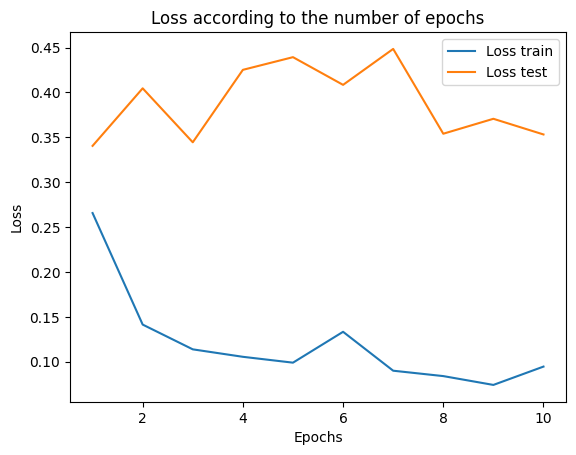

In [63]:
plt.plot(np.arange(1,11), loss_train, label='Loss train')
plt.plot(np.arange(1,11), loss_test, label='Loss test')
plt.legend()
plt.title('Loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

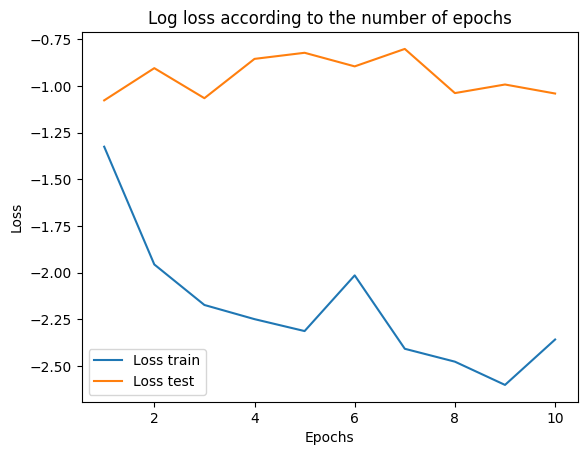

In [64]:
plt.plot(np.arange(1,11), np.log(loss_train), label='Loss train')
plt.plot(np.arange(1,11), np.log(loss_test), label='Loss test')
plt.legend()
plt.title('Log loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

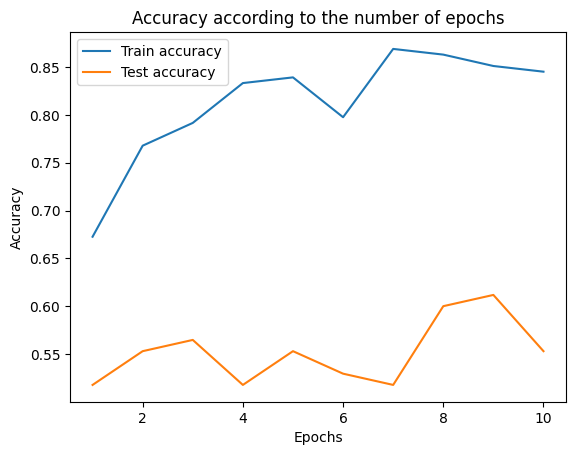

In [65]:
plt.plot(np.arange(1,11), acc_train, label='Train accuracy')
plt.plot(np.arange(1,11), acc_test, label='Test accuracy')
plt.legend()
plt.title('Accuracy according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Confusion Matrix, Without Normalization


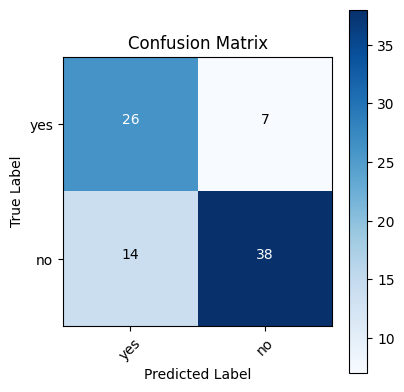

              precision    recall  f1-score   support

         yes       0.65      0.79      0.71        33
          no       0.84      0.73      0.78        52

    accuracy                           0.75        85
   macro avg       0.75      0.76      0.75        85
weighted avg       0.77      0.75      0.76        85



In [66]:
labels, predictions = predict(model_eff_net2, test_loader)

target_names = ['yes','no']

cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

print(classification_report(labels, predictions, target_names= target_names))

### Summary

In [67]:
results = {'Accuracy':[accuracy_score(predict(model_eff_net0, test_loader)[0],predict(model_eff_net0, test_loader)[1]),
                       accuracy_score(predict(model_eff_net1, test_loader)[0],predict(model_eff_net1, test_loader)[1]),
                       accuracy_score(predict(model_eff_net2, test_loader)[0],predict(model_eff_net2, test_loader)[1]),
                       accuracy_score(predict(model_eff_net6, test_loader)[0],predict(model_eff_net6, test_loader)[1]),
                       accuracy_score(predict(model_eff_net7, test_loader)[0],predict(model_eff_net7, test_loader)[1])],
           'Precision':[precision_score(predict(model_eff_net0, test_loader)[0],predict(model_eff_net0, test_loader)[1]),
                       precision_score(predict(model_eff_net1, test_loader)[0],predict(model_eff_net1, test_loader)[1]),
                       precision_score(predict(model_eff_net2, test_loader)[0],predict(model_eff_net2, test_loader)[1]),
                       precision_score(predict(model_eff_net6, test_loader)[0],predict(model_eff_net6, test_loader)[1]),
                       precision_score(predict(model_eff_net7, test_loader)[0],predict(model_eff_net7, test_loader)[1])],
           'Recall':[recall_score(predict(model_eff_net0, test_loader)[0],predict(model_eff_net0, test_loader)[1]),
                     recall_score(predict(model_eff_net1, test_loader)[0],predict(model_eff_net1, test_loader)[1]),
                     recall_score(predict(model_eff_net2, test_loader)[0],predict(model_eff_net2, test_loader)[1]),
                     recall_score(predict(model_eff_net6, test_loader)[0],predict(model_eff_net6, test_loader)[1]),
                     recall_score(predict(model_eff_net7, test_loader)[0],predict(model_eff_net7, test_loader)[1])],
           'F1-score':[f1_score(predict(model_eff_net0, test_loader)[0],predict(model_eff_net0, test_loader)[1]),
                     f1_score(predict(model_eff_net1, test_loader)[0],predict(model_eff_net1, test_loader)[1]),
                     f1_score(predict(model_eff_net2, test_loader)[0],predict(model_eff_net2, test_loader)[1]),
                     f1_score(predict(model_eff_net6, test_loader)[0],predict(model_eff_net6, test_loader)[1]),
                     f1_score(predict(model_eff_net7, test_loader)[0],predict(model_eff_net7, test_loader)[1])]}

pd.DataFrame(results, index=['EfficientNet b0', 'EfficientNet b1', 'EfficientNet b2', 'EfficientNet b6', 'EfficientNet b7'])

,Accuracy,Precision,Recall,F1-score
EfficientNet b0,0.811765,0.875000,0.807692,0.840000
EfficientNet b1,0.800000,0.843137,0.826923,0.834951
EfficientNet b2,0.752941,0.844444,0.730769,0.783505
EfficientNet b6,0.823529,0.930233,0.769231,0.842105
EfficientNet b7,0.823529,0.836364,0.884615,0.859813


In [68]:
eff_net_results = pd.DataFrame(results, index=['EfficientNet b0', 'EfficientNet b1', 'EfficientNet b2', 'EfficientNet b6', 'EfficientNet b7'])

## Resnet

### Resnet 50

In [69]:
model_res50 = models.resnet50(weights='DEFAULT')

In [70]:
model_res50 = model_res50.to(device)

In [71]:
print(model_res50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [72]:
print(model_res50.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [73]:
for param in model_res50.parameters():
    param.requires_grad = False

model_res50.fc = nn.Linear(2048, 2)

model_res50_lsm = nn.Sequential(model_res50, torch.nn.LogSoftmax(dim = 1))

In [74]:
print(model_res50_lsm)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [75]:
model_res50_lsm = model_res50_lsm.to(device)

In [76]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-4
optimizer_cl = torch.optim.RMSprop(model_res50_lsm.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_res50_lsm, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 0.2259 Acc: 0.6369


 10%|█         | 1/10 [00:28<04:19, 28.89s/it]

Test - Loss: 0.2564 Acc: 0.5059
Train - Loss: 0.0569 Acc: 0.8810


 20%|██        | 2/10 [00:56<03:43, 27.88s/it]

Test - Loss: 0.1780 Acc: 0.6353
Train - Loss: 0.0581 Acc: 0.8512


 30%|███       | 3/10 [01:23<03:13, 27.65s/it]

Test - Loss: 0.1711 Acc: 0.5647
Train - Loss: 0.0641 Acc: 0.8214


 40%|████      | 4/10 [01:50<02:45, 27.54s/it]

Test - Loss: 0.1972 Acc: 0.5647
Train - Loss: 0.0476 Acc: 0.8869


 50%|█████     | 5/10 [02:18<02:17, 27.52s/it]

Test - Loss: 0.1947 Acc: 0.6000
Train - Loss: 0.0423 Acc: 0.8810


 60%|██████    | 6/10 [02:44<01:48, 27.23s/it]

Test - Loss: 0.1826 Acc: 0.6353
Train - Loss: 0.0150 Acc: 0.9524


 70%|███████   | 7/10 [03:12<01:22, 27.37s/it]

Test - Loss: 0.1812 Acc: 0.6235
Train - Loss: 0.0201 Acc: 0.9405


 80%|████████  | 8/10 [03:39<00:54, 27.32s/it]

Test - Loss: 0.1778 Acc: 0.6000
Train - Loss: 0.0191 Acc: 0.9405


 90%|█████████ | 9/10 [04:07<00:27, 27.41s/it]

Test - Loss: 0.1814 Acc: 0.6000
Train - Loss: 0.0065 Acc: 0.9821


100%|██████████| 10/10 [04:35<00:00, 27.54s/it]

Test - Loss: 0.1967 Acc: 0.6118


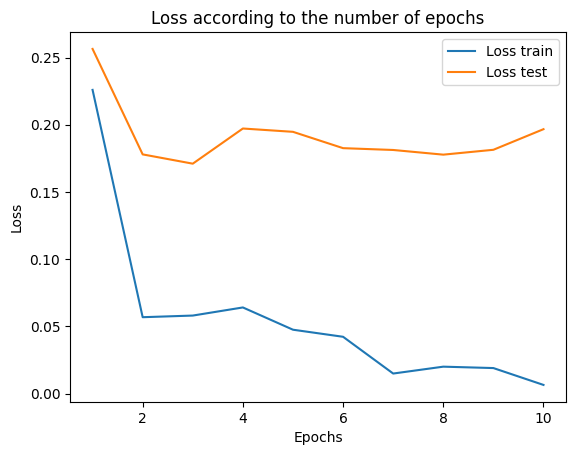

In [77]:
plt.plot(np.arange(1,11), loss_train, label='Loss train')
plt.plot(np.arange(1,11), loss_test, label='Loss test')
plt.legend()
plt.title('Loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

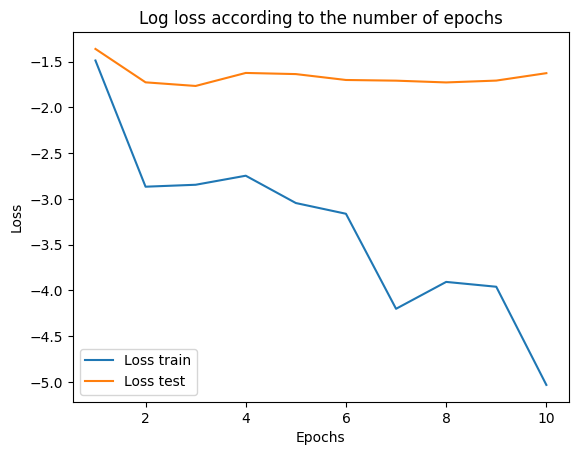

In [78]:
plt.plot(np.arange(1,11), np.log(loss_train), label='Loss train')
plt.plot(np.arange(1,11), np.log(loss_test), label='Loss test')
plt.legend()
plt.title('Log loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

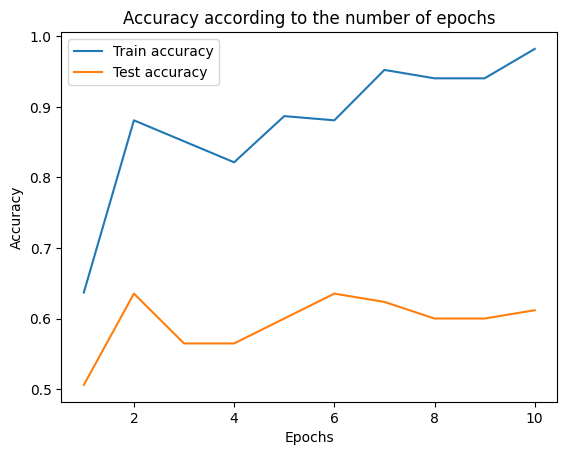

In [79]:
plt.plot(np.arange(1,11), acc_train, label='Train accuracy')
plt.plot(np.arange(1,11), acc_test, label='Test accuracy')
plt.legend()
plt.title('Accuracy according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Confusion Matrix, Without Normalization


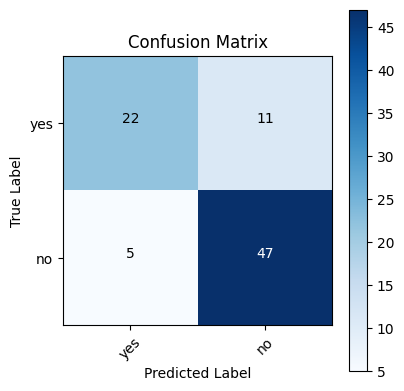

              precision    recall  f1-score   support

         yes       0.81      0.67      0.73        33
          no       0.81      0.90      0.85        52

    accuracy                           0.81        85
   macro avg       0.81      0.79      0.79        85
weighted avg       0.81      0.81      0.81        85



In [80]:
labels, predictions = predict(model_res50_lsm, test_loader)

target_names = ['yes','no']

cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

print(classification_report(labels, predictions, target_names= target_names))

### Resnet 34

In [81]:
model_res34 = models.resnet34(weights='DEFAULT')

In [82]:
model_res34 = model_res34.to(device)

In [83]:
print(model_res34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [84]:
print(model_res34.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [85]:
for param in model_res34.parameters():
    param.requires_grad = False

model_res34.fc = nn.Linear(512, 2)

model_res34_lsm = nn.Sequential(model_res34, torch.nn.LogSoftmax(dim = 1))

In [86]:
print(model_res34_lsm)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [87]:
model_res34_lsm = model_res34_lsm.to(device)

In [88]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_res34_lsm.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_res34_lsm, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 0.9303 Acc: 0.6190


 10%|█         | 1/10 [00:28<04:16, 28.48s/it]

Test - Loss: 0.9513 Acc: 0.6118
Train - Loss: 0.1827 Acc: 0.7560


 20%|██        | 2/10 [00:55<03:42, 27.86s/it]

Test - Loss: 0.5944 Acc: 0.5882
Train - Loss: 0.1381 Acc: 0.8095


 30%|███       | 3/10 [01:24<03:16, 28.09s/it]

Test - Loss: 0.3882 Acc: 0.5176
Train - Loss: 0.1182 Acc: 0.8571


 40%|████      | 4/10 [01:51<02:46, 27.78s/it]

Test - Loss: 0.4845 Acc: 0.4706
Train - Loss: 0.1110 Acc: 0.8393


 50%|█████     | 5/10 [02:20<02:20, 28.04s/it]

Test - Loss: 0.4163 Acc: 0.5059
Train - Loss: 0.0695 Acc: 0.8810


 60%|██████    | 6/10 [02:46<01:50, 27.66s/it]

Test - Loss: 0.3859 Acc: 0.5412
Train - Loss: 0.0643 Acc: 0.8690


 70%|███████   | 7/10 [03:14<01:22, 27.63s/it]

Test - Loss: 0.4270 Acc: 0.5176
Train - Loss: 0.0836 Acc: 0.8690


 80%|████████  | 8/10 [03:42<00:55, 27.78s/it]

Test - Loss: 0.4068 Acc: 0.5765
Train - Loss: 0.1087 Acc: 0.8869


 90%|█████████ | 9/10 [04:10<00:27, 27.74s/it]

Test - Loss: 0.4288 Acc: 0.5294
Train - Loss: 0.0419 Acc: 0.9226


100%|██████████| 10/10 [04:38<00:00, 27.82s/it]

Test - Loss: 0.4708 Acc: 0.4941


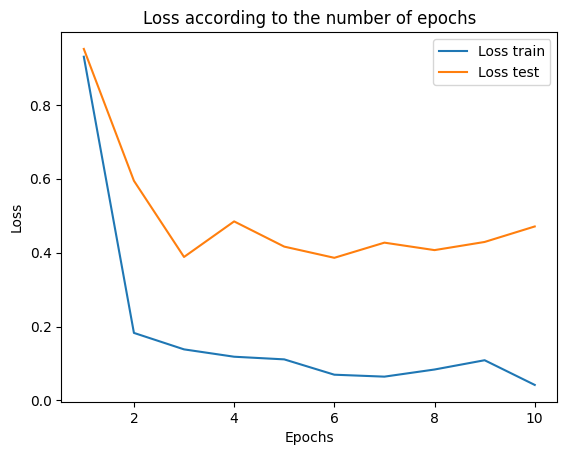

In [89]:
plt.plot(np.arange(1,11), loss_train, label='Loss train')
plt.plot(np.arange(1,11), loss_test, label='Loss test')
plt.legend()
plt.title('Loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

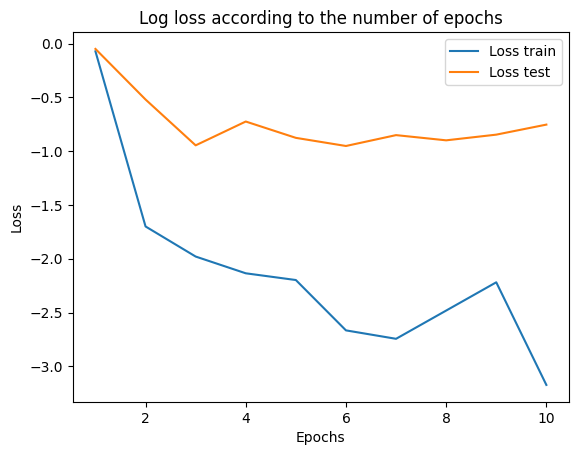

In [90]:
plt.plot(np.arange(1,11), np.log(loss_train), label='Loss train')
plt.plot(np.arange(1,11), np.log(loss_test), label='Loss test')
plt.legend()
plt.title('Log loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

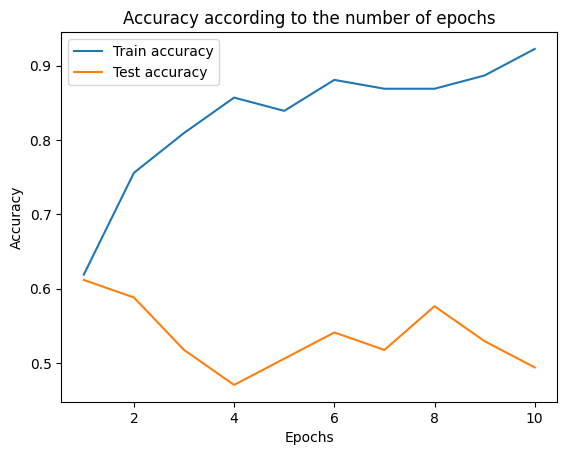

In [91]:
plt.plot(np.arange(1,11), acc_train, label='Train accuracy')
plt.plot(np.arange(1,11), acc_test, label='Test accuracy')
plt.legend()
plt.title('Accuracy according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Confusion Matrix, Without Normalization


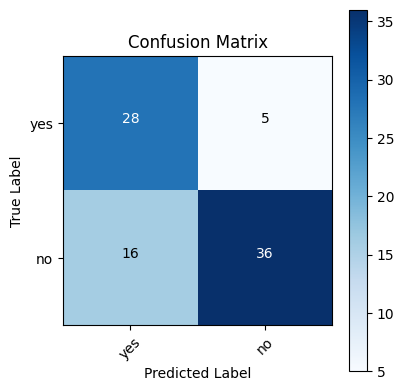

              precision    recall  f1-score   support

         yes       0.64      0.85      0.73        33
          no       0.88      0.69      0.77        52

    accuracy                           0.75        85
   macro avg       0.76      0.77      0.75        85
weighted avg       0.78      0.75      0.76        85



In [92]:
labels, predictions = predict(model_res34_lsm, test_loader)

target_names = ['yes','no']

cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

print(classification_report(labels, predictions, target_names= target_names))

### Resnet 152

In [93]:
model_res152 = models.resnet152(weights='DEFAULT')

In [94]:
model_res152 = model_res152.to(device)

In [95]:
print(model_res152)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [96]:
print(model_res152.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [97]:
for param in model_res152.parameters():
    param.requires_grad = False

model_res152.fc = nn.Linear(2048, 2)

model_res152_lsm = nn.Sequential(model_res152, torch.nn.LogSoftmax(dim = 1))

In [98]:
print(model_res152_lsm)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [99]:
model_res152_lsm = model_res152_lsm.to(device)

In [100]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_res152_lsm.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_res152_lsm, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 0.2991 Acc: 0.6488


 10%|█         | 1/10 [00:29<04:24, 29.43s/it]

Test - Loss: 0.3811 Acc: 0.5647
Train - Loss: 0.0748 Acc: 0.8512


 20%|██        | 2/10 [00:57<03:49, 28.72s/it]

Test - Loss: 0.3432 Acc: 0.5412
Train - Loss: 0.0723 Acc: 0.8571


 30%|███       | 3/10 [01:26<03:20, 28.58s/it]

Test - Loss: 0.2832 Acc: 0.5529
Train - Loss: 0.0462 Acc: 0.9286


 40%|████      | 4/10 [01:55<02:53, 28.85s/it]

Test - Loss: 0.2545 Acc: 0.5059
Train - Loss: 0.0240 Acc: 0.9464


 50%|█████     | 5/10 [02:24<02:25, 29.03s/it]

Test - Loss: 0.3563 Acc: 0.6118
Train - Loss: 0.0146 Acc: 0.9345


 60%|██████    | 6/10 [02:54<01:56, 29.19s/it]

Test - Loss: 0.2433 Acc: 0.5176
Train - Loss: 0.0375 Acc: 0.9226


 70%|███████   | 7/10 [03:22<01:26, 28.97s/it]

Test - Loss: 0.2471 Acc: 0.5412
Train - Loss: 0.0217 Acc: 0.9583


 80%|████████  | 8/10 [03:51<00:57, 28.77s/it]

Test - Loss: 0.2461 Acc: 0.6118
Train - Loss: 0.0300 Acc: 0.9286


 90%|█████████ | 9/10 [04:19<00:28, 28.58s/it]

Test - Loss: 0.2369 Acc: 0.6588
Train - Loss: 0.0321 Acc: 0.9286


100%|██████████| 10/10 [04:48<00:00, 28.83s/it]

Test - Loss: 0.2362 Acc: 0.5529


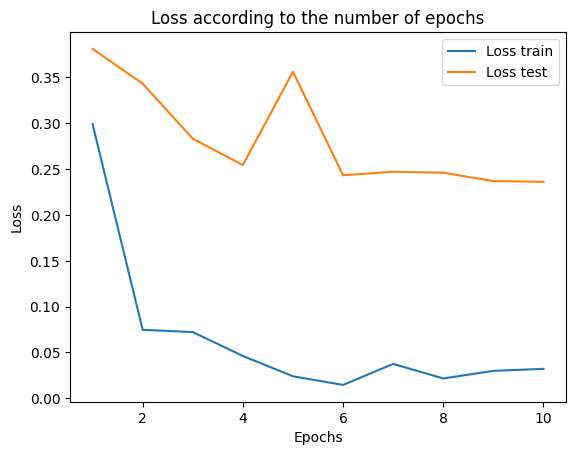

In [101]:
plt.plot(np.arange(1,11), loss_train, label='Loss train')
plt.plot(np.arange(1,11), loss_test, label='Loss test')
plt.legend()
plt.title('Loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

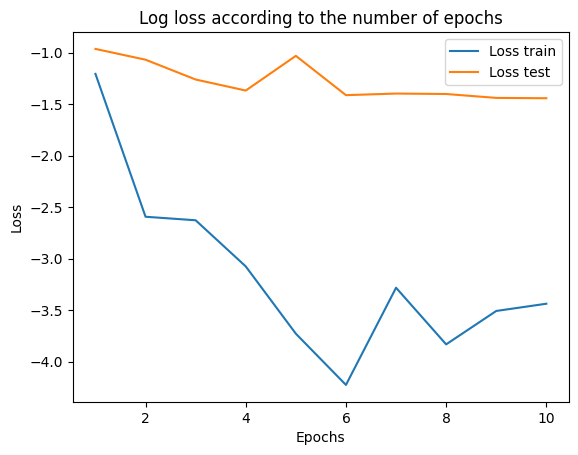

In [102]:
plt.plot(np.arange(1,11), np.log(loss_train), label='Loss train')
plt.plot(np.arange(1,11), np.log(loss_test), label='Loss test')
plt.legend()
plt.title('Log loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

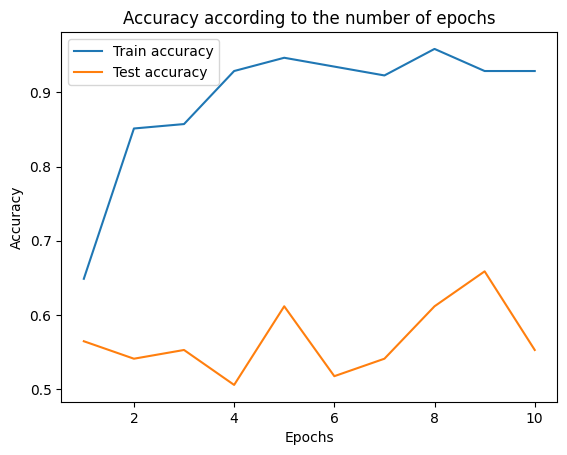

In [103]:
plt.plot(np.arange(1,11), acc_train, label='Train accuracy')
plt.plot(np.arange(1,11), acc_test, label='Test accuracy')
plt.legend()
plt.title('Accuracy according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Confusion Matrix, Without Normalization


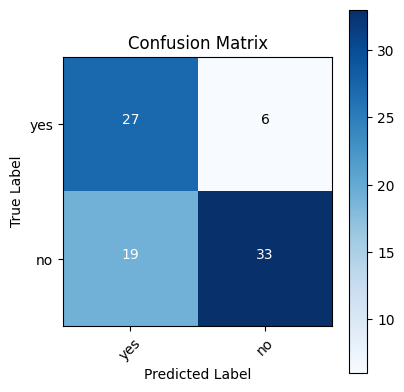

              precision    recall  f1-score   support

         yes       0.59      0.82      0.68        33
          no       0.85      0.63      0.73        52

    accuracy                           0.71        85
   macro avg       0.72      0.73      0.70        85
weighted avg       0.75      0.71      0.71        85



In [104]:
labels, predictions = predict(model_res152_lsm, test_loader)

target_names = ['yes','no']

cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

print(classification_report(labels, predictions, target_names= target_names))

### Results

In [105]:
results = {'Accuracy':[accuracy_score(predict(model_res34_lsm, test_loader)[0],predict(model_res34_lsm, test_loader)[1]),
                       accuracy_score(predict(model_res50_lsm, test_loader)[0],predict(model_res50_lsm, test_loader)[1]),
                       accuracy_score(predict(model_res152_lsm, test_loader)[0],predict(model_res152_lsm, test_loader)[1])],
           'Precision':[precision_score(predict(model_res34_lsm, test_loader)[0],predict(model_res34_lsm, test_loader)[1]),
                       precision_score(predict(model_res50_lsm, test_loader)[0],predict(model_res50_lsm, test_loader)[1]),
                       precision_score(predict(model_res152_lsm, test_loader)[0],predict(model_res152_lsm, test_loader)[1])],
           'Recall':[recall_score(predict(model_res34_lsm, test_loader)[0],predict(model_res34_lsm, test_loader)[1]),
                     recall_score(predict(model_res50_lsm, test_loader)[0],predict(model_res50_lsm, test_loader)[1]),
                     recall_score(predict(model_res152_lsm, test_loader)[0],predict(model_res152_lsm, test_loader)[1])],
           'F1-score':[f1_score(predict(model_res34_lsm, test_loader)[0],predict(model_res34_lsm, test_loader)[1]),
                     f1_score(predict(model_res50_lsm, test_loader)[0],predict(model_res50_lsm, test_loader)[1]),
                     f1_score(predict(model_res152_lsm, test_loader)[0],predict(model_res152_lsm, test_loader)[1])]}

resnet_result = pd.DataFrame(results, index=['Resnet34', 'Resnet50', 'Resnet152'])

results = pd.concat([eff_net_results, resnet_result], axis=0)

In [106]:
results

,Accuracy,Precision,Recall,F1-score
EfficientNet b0,0.811765,0.875000,0.807692,0.840000
EfficientNet b1,0.800000,0.843137,0.826923,0.834951
EfficientNet b2,0.752941,0.844444,0.730769,0.783505
EfficientNet b6,0.823529,0.930233,0.769231,0.842105
EfficientNet b7,0.823529,0.836364,0.884615,0.859813
Resnet34,0.752941,0.878049,0.692308,0.774194
Resnet50,0.811765,0.810345,0.903846,0.854545
Resnet152,0.705882,0.846154,0.634615,0.725275


## VGG 

### VGG11

In [107]:
model_vgg11 = models.vgg11()

In [108]:
print(model_vgg11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [109]:
model_vgg11 = model_vgg11.to(device)

In [110]:
for param in model_vgg11.parameters():
    param.requires_grad = False

model_vgg11.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))

model_vgg11.classifier._modules['0'] = nn.Linear(512*2*2, 4096)
model_vgg11.classifier._modules['6'] = nn.Linear(4096, 2)
model_vgg11.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [111]:
print(model_vgg11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [112]:
model_vgg11 = model_vgg11.to(device)

In [113]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_vgg11.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_vgg11, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 8.5247 Acc: 0.5833


 10%|█         | 1/10 [00:27<04:09, 27.68s/it]

Test - Loss: 5.7706 Acc: 0.4118
Train - Loss: 3.5921 Acc: 0.6012


 20%|██        | 2/10 [00:54<03:36, 27.11s/it]

Test - Loss: 1.4077 Acc: 0.6118
Train - Loss: 2.6769 Acc: 0.5893


 30%|███       | 3/10 [01:20<03:07, 26.76s/it]

Test - Loss: 2.5608 Acc: 0.4824
Train - Loss: 2.4337 Acc: 0.5060


 40%|████      | 4/10 [01:47<02:39, 26.59s/it]

Test - Loss: 1.4753 Acc: 0.5294
Train - Loss: 1.7385 Acc: 0.5476


 50%|█████     | 5/10 [02:13<02:12, 26.59s/it]

Test - Loss: 1.3447 Acc: 0.5882
Train - Loss: 1.8679 Acc: 0.5298


 60%|██████    | 6/10 [02:41<01:47, 26.93s/it]

Test - Loss: 1.0292 Acc: 0.6353
Train - Loss: 1.0847 Acc: 0.5595


 70%|███████   | 7/10 [03:07<01:20, 26.71s/it]

Test - Loss: 0.9174 Acc: 0.6235
Train - Loss: 1.1544 Acc: 0.5893


 80%|████████  | 8/10 [03:34<00:53, 26.87s/it]

Test - Loss: 0.8751 Acc: 0.5294
Train - Loss: 0.7112 Acc: 0.5833


 90%|█████████ | 9/10 [04:02<00:27, 27.14s/it]

Test - Loss: 0.7308 Acc: 0.5529
Train - Loss: 0.7921 Acc: 0.6071


100%|██████████| 10/10 [04:30<00:00, 27.01s/it]

Test - Loss: 0.5956 Acc: 0.5176


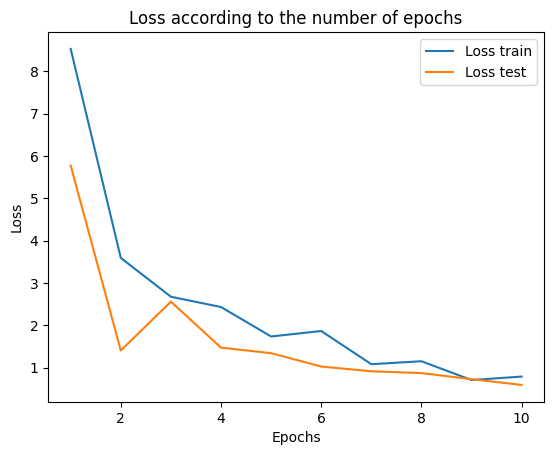

In [114]:
plt.plot(np.arange(1,11), loss_train, label='Loss train')
plt.plot(np.arange(1,11), loss_test, label='Loss test')
plt.legend()
plt.title('Loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

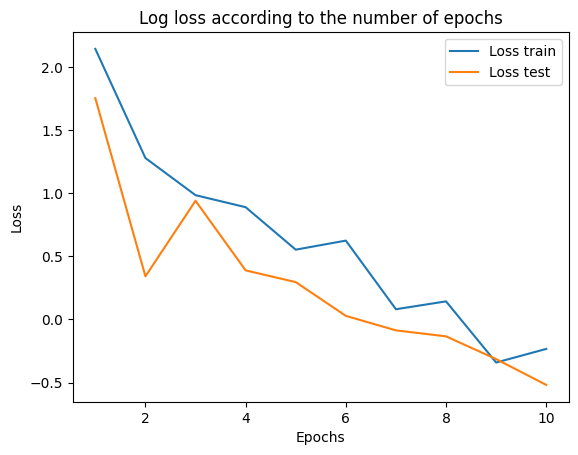

In [115]:
plt.plot(np.arange(1,11), np.log(loss_train), label='Loss train')
plt.plot(np.arange(1,11), np.log(loss_test), label='Loss test')
plt.legend()
plt.title('Log loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

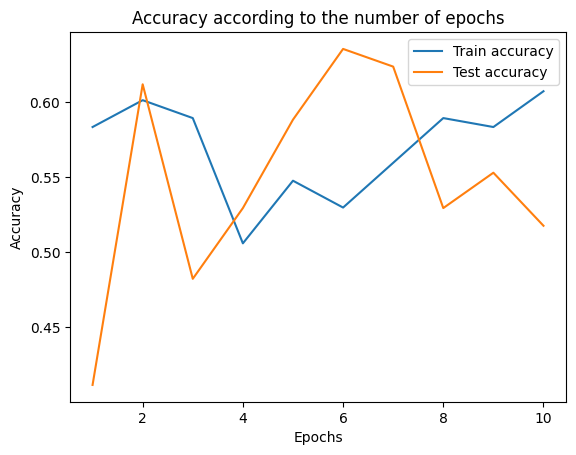

In [116]:
plt.plot(np.arange(1,11), acc_train, label='Train accuracy')
plt.plot(np.arange(1,11), acc_test, label='Test accuracy')
plt.legend()
plt.title('Accuracy according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Confusion Matrix, Without Normalization


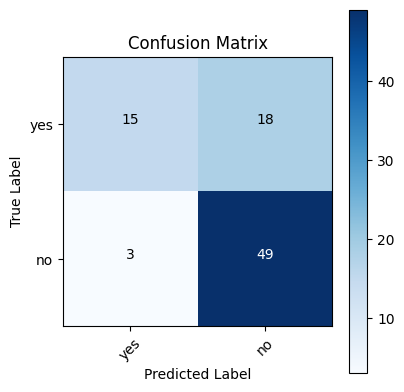

              precision    recall  f1-score   support

         yes       0.83      0.45      0.59        33
          no       0.73      0.94      0.82        52

    accuracy                           0.75        85
   macro avg       0.78      0.70      0.71        85
weighted avg       0.77      0.75      0.73        85



In [117]:
labels, predictions = predict(model_vgg11, test_loader)

target_names = ['yes','no']

cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

print(classification_report(labels, predictions, target_names= target_names))

### VGG 16

In [118]:
model_vgg16 = models.vgg16()

In [119]:
print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [120]:
model_vgg16 = model_vgg16.to(device)

In [121]:
print(model_vgg16.avgpool)

AdaptiveAvgPool2d(output_size=(7, 7))


In [122]:
for param in model_vgg16.parameters():
    param.requires_grad = False

model_vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))

model_vgg16.classifier._modules['0'] = nn.Linear(512*2*2, 4096)
model_vgg16.classifier._modules['6'] = nn.Linear(4096, 2)
model_vgg16.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [123]:
print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [124]:
model_vgg16 = model_vgg16.to(device)

In [125]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_vgg16.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_vgg16, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 8.1506 Acc: 0.4524


 10%|█         | 1/10 [00:29<04:25, 29.52s/it]

Test - Loss: 4.6908 Acc: 0.3882
Train - Loss: 3.2625 Acc: 0.4643


 20%|██        | 2/10 [00:59<03:56, 29.55s/it]

Test - Loss: 3.1123 Acc: 0.6118
Train - Loss: 1.4993 Acc: 0.5476


 30%|███       | 3/10 [01:28<03:25, 29.33s/it]

Test - Loss: 1.0541 Acc: 0.5647
Train - Loss: 1.3609 Acc: 0.5893


 40%|████      | 4/10 [01:56<02:53, 28.88s/it]

Test - Loss: 1.4205 Acc: 0.4118
Train - Loss: 1.0989 Acc: 0.5714


 50%|█████     | 5/10 [02:24<02:22, 28.49s/it]

Test - Loss: 1.0421 Acc: 0.5529
Train - Loss: 1.1771 Acc: 0.5179


 60%|██████    | 6/10 [02:53<01:55, 28.81s/it]

Test - Loss: 1.2141 Acc: 0.5765
Train - Loss: 1.2091 Acc: 0.5000


 70%|███████   | 7/10 [03:21<01:25, 28.50s/it]

Test - Loss: 0.6420 Acc: 0.5529
Train - Loss: 0.7484 Acc: 0.5595


 80%|████████  | 8/10 [03:49<00:56, 28.39s/it]

Test - Loss: 0.7626 Acc: 0.5294
Train - Loss: 0.4525 Acc: 0.6607


 90%|█████████ | 9/10 [04:17<00:28, 28.37s/it]

Test - Loss: 0.5005 Acc: 0.6353
Train - Loss: 0.4772 Acc: 0.5952


100%|██████████| 10/10 [04:45<00:00, 28.56s/it]

Test - Loss: 0.3405 Acc: 0.5294


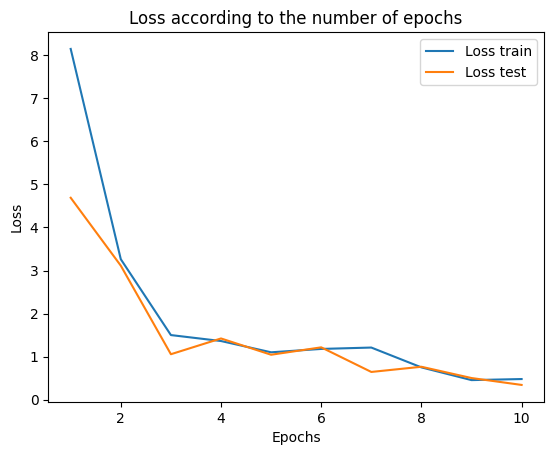

In [126]:
plt.plot(np.arange(1,11), loss_train, label='Loss train')
plt.plot(np.arange(1,11), loss_test, label='Loss test')
plt.legend()
plt.title('Loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

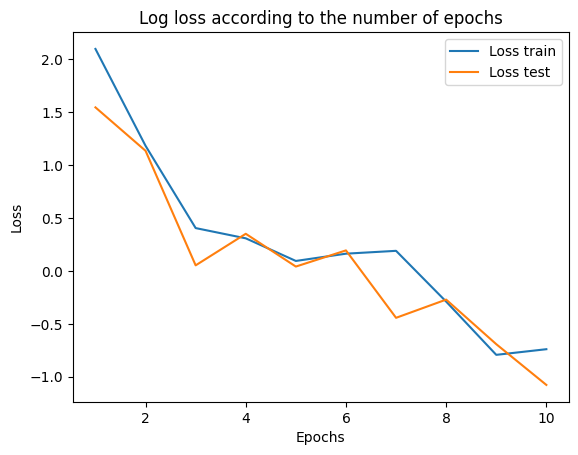

In [127]:
plt.plot(np.arange(1,11), np.log(loss_train), label='Loss train')
plt.plot(np.arange(1,11), np.log(loss_test), label='Loss test')
plt.legend()
plt.title('Log loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

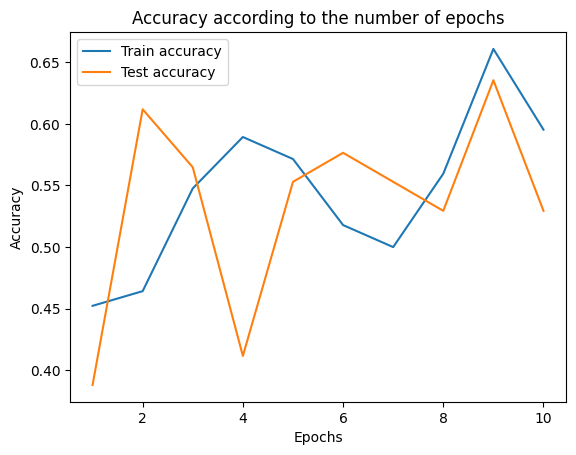

In [128]:
plt.plot(np.arange(1,11), acc_train, label='Train accuracy')
plt.plot(np.arange(1,11), acc_test, label='Test accuracy')
plt.legend()
plt.title('Accuracy according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Confusion Matrix, Without Normalization


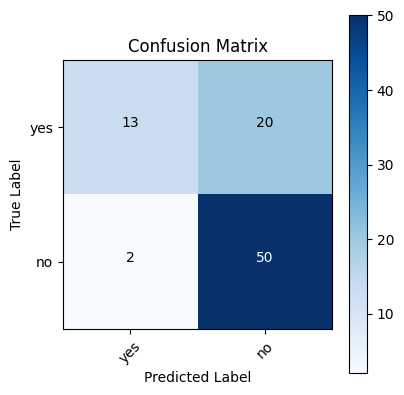

              precision    recall  f1-score   support

         yes       0.87      0.39      0.54        33
          no       0.71      0.96      0.82        52

    accuracy                           0.74        85
   macro avg       0.79      0.68      0.68        85
weighted avg       0.77      0.74      0.71        85



In [129]:
labels, predictions = predict(model_vgg16, test_loader)

target_names = ['yes','no']

cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

print(classification_report(labels, predictions, target_names= target_names))

### VGG 19

In [130]:
model_vgg19 = models.vgg19()

In [131]:
print(model_vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [132]:
model_vgg19 = model_vgg19.to(device)

In [133]:
print(model_vgg19.avgpool)

AdaptiveAvgPool2d(output_size=(7, 7))


In [134]:
for param in model_vgg19.parameters():
    param.requires_grad = False

model_vgg19.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))

model_vgg19.classifier._modules['0'] = nn.Linear(512*2*2, 4096)
model_vgg19.classifier._modules['6'] = nn.Linear(4096, 2)
model_vgg19.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [135]:
print(model_vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [136]:
model_vgg19 = model_vgg19.to(device)

In [137]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_vgg19.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_vgg19, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 7.7853 Acc: 0.5119


 10%|█         | 1/10 [00:27<04:07, 27.51s/it]

Test - Loss: 1.2151 Acc: 0.5882
Train - Loss: 1.8295 Acc: 0.5417


 20%|██        | 2/10 [00:54<03:36, 27.08s/it]

Test - Loss: 0.8285 Acc: 0.4824
Train - Loss: 1.2085 Acc: 0.5060


 30%|███       | 3/10 [01:24<03:19, 28.56s/it]

Test - Loss: 1.3572 Acc: 0.4471
Train - Loss: 1.3608 Acc: 0.4762


 40%|████      | 4/10 [01:52<02:49, 28.24s/it]

Test - Loss: 0.5757 Acc: 0.5882
Train - Loss: 0.8475 Acc: 0.5595


 50%|█████     | 5/10 [02:20<02:21, 28.32s/it]

Test - Loss: 0.5359 Acc: 0.5059
Train - Loss: 0.5655 Acc: 0.6012


 60%|██████    | 6/10 [02:48<01:52, 28.24s/it]

Test - Loss: 0.3705 Acc: 0.5412
Train - Loss: 0.4907 Acc: 0.5298


 70%|███████   | 7/10 [03:16<01:24, 28.19s/it]

Test - Loss: 0.3507 Acc: 0.6235
Train - Loss: 0.3774 Acc: 0.5714


 80%|████████  | 8/10 [03:45<00:56, 28.23s/it]

Test - Loss: 0.2641 Acc: 0.5294
Train - Loss: 0.2832 Acc: 0.5595


 90%|█████████ | 9/10 [04:13<00:28, 28.27s/it]

Test - Loss: 0.1703 Acc: 0.5412
Train - Loss: 0.1777 Acc: 0.5833


100%|██████████| 10/10 [04:42<00:00, 28.20s/it]

Test - Loss: 0.1157 Acc: 0.6353


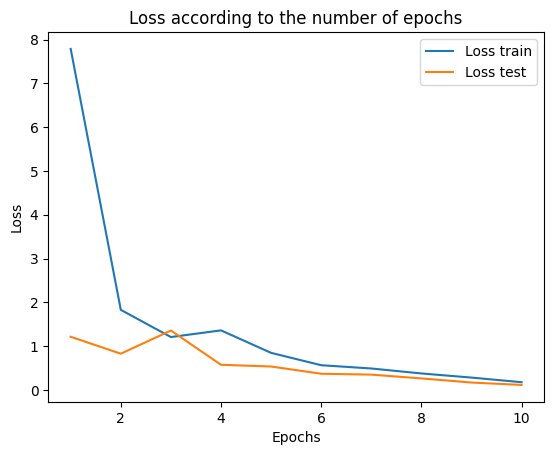

In [138]:
plt.plot(np.arange(1,11), loss_train, label='Loss train')
plt.plot(np.arange(1,11), loss_test, label='Loss test')
plt.legend()
plt.title('Loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

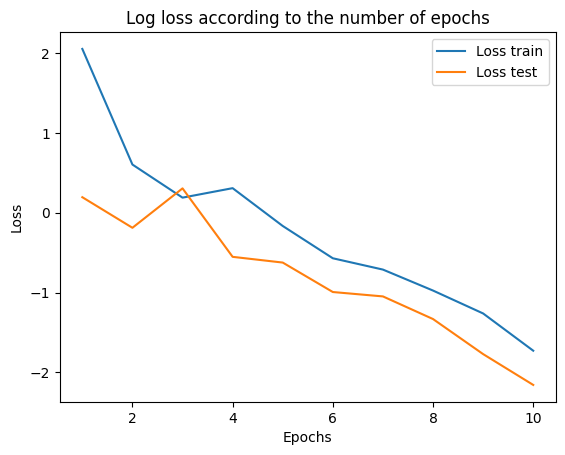

In [139]:
plt.plot(np.arange(1,11), np.log(loss_train), label='Loss train')
plt.plot(np.arange(1,11), np.log(loss_test), label='Loss test')
plt.legend()
plt.title('Log loss according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

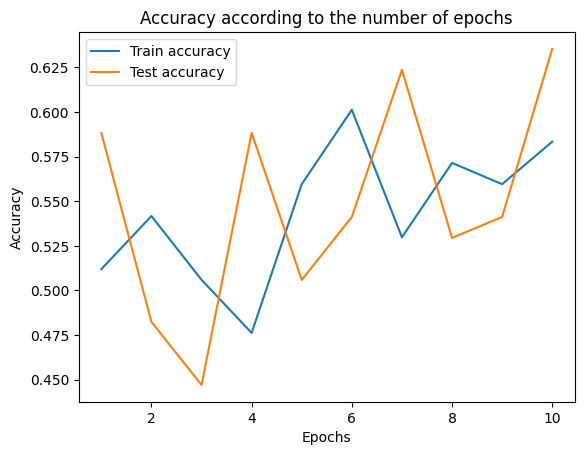

In [140]:
plt.plot(np.arange(1,11), acc_train, label='Train accuracy')
plt.plot(np.arange(1,11), acc_test, label='Test accuracy')
plt.legend()
plt.title('Accuracy according to the number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Confusion Matrix, Without Normalization


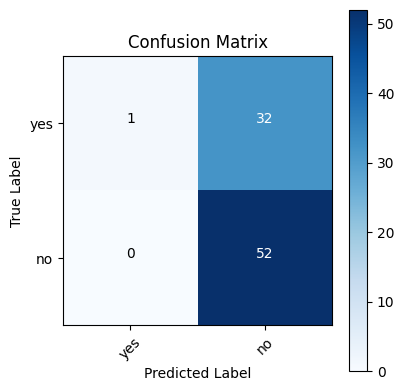

              precision    recall  f1-score   support

         yes       1.00      0.03      0.06        33
          no       0.62      1.00      0.76        52

    accuracy                           0.62        85
   macro avg       0.81      0.52      0.41        85
weighted avg       0.77      0.62      0.49        85



In [141]:
labels, predictions = predict(model_vgg19, test_loader)

target_names = ['yes','no']

cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

print(classification_report(labels, predictions, target_names= target_names))

### Results

In [142]:
results = {'Accuracy':[accuracy_score(predict(model_vgg11, test_loader)[0],predict(model_vgg11, test_loader)[1]),
                       accuracy_score(predict(model_vgg16, test_loader)[0],predict(model_vgg16, test_loader)[1]),
                       accuracy_score(predict(model_vgg19, test_loader)[0],predict(model_vgg19, test_loader)[1])],
           'Precision':[precision_score(predict(model_vgg11, test_loader)[0],predict(model_vgg11, test_loader)[1]),
                       precision_score(predict(model_vgg16, test_loader)[0],predict(model_vgg16, test_loader)[1]),
                       precision_score(predict(model_vgg19, test_loader)[0],predict(model_vgg19, test_loader)[1])],
           'Recall':[recall_score(predict(model_vgg11, test_loader)[0],predict(model_vgg11, test_loader)[1]),
                     recall_score(predict(model_vgg16, test_loader)[0],predict(model_vgg16, test_loader)[1]),
                     recall_score(predict(model_vgg19, test_loader)[0],predict(model_vgg19, test_loader)[1])],
           'F1-score':[f1_score(predict(model_vgg11, test_loader)[0],predict(model_vgg11, test_loader)[1]),
                     f1_score(predict(model_vgg16, test_loader)[0],predict(model_vgg16, test_loader)[1]),
                     f1_score(predict(model_vgg19, test_loader)[0],predict(model_vgg19, test_loader)[1])]}

vgg_result = pd.DataFrame(results, index=['VGG 11', 'VGG 16', 'VGG 19'])

results = pd.concat([eff_net_results, resnet_result, vgg_result], axis=0)

In [143]:
results

,Accuracy,Precision,Recall,F1-score
EfficientNet b0,0.811765,0.875000,0.807692,0.840000
EfficientNet b1,0.800000,0.843137,0.826923,0.834951
EfficientNet b2,0.752941,0.844444,0.730769,0.783505
EfficientNet b6,0.823529,0.930233,0.769231,0.842105
EfficientNet b7,0.823529,0.836364,0.884615,0.859813
Resnet34,0.752941,0.878049,0.692308,0.774194
Resnet50,0.811765,0.810345,0.903846,0.854545
Resnet152,0.705882,0.846154,0.634615,0.725275
VGG 11,0.752941,0.731343,0.942308,0.823529
VGG 16,0.741176,0.714286,0.961538,0.819672
